In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import matplotlib.animation
import matplotlib
import numpy as np
from numba import jit, njit, prange

### Staggered Grid Elastic Wave Equation

#### Elastic wave equation 2D anisotropic media as first order sytem of equations

<img src="elastic anisotropic equations for 2D media.png" alt="staggered grid" width="500">



#### Elastic wave equation 2D isotropic media 

$$ C_{15} = C_{35} =  0 $$
$$ C_{11} = C_{33}= \lambda + 2\mu $$
$$ C_{13} = \lambda $$
$$ C_{55} = \mu $$


- https://en.wikipedia.org/wiki/Linear_elasticity  
- https://en.wikipedia.org/wiki/Lam%C3%A9_parameters

$$ \normalsize  \rho\partial_tV_x-\partial_x\tau_{xx} -\partial_z\tau_{xz} = f_x $$
$$ \normalsize  \rho\partial_tV_z-\partial_x\tau_{xz} -\partial_z\tau_{zz} = f_z $$

$$\normalsize \partial_t\tau_{xx} - \left( \lambda + 2\mu \right) \partial_xV_x - \lambda\partial_zV_z = -\partial_t g_{xx} $$
$$\normalsize  \partial_t\tau_{zz} - \left( \lambda + 2\mu \right) \partial_zV_z - \lambda\partial_xV_x = -\partial_t g_{zz} $$

$$\normalsize  \partial_t\tau_{xz} - \mu \left( \partial_xV_z + \partial_zV_x  \right) = -\partial_t g_{xz} $$

Where:
- $\tau_{ij}$ are the stress components
- $\rho$ is the mass density
- $g_{ij}$ stress components due external strain applied (source)
- $V_{x/z}$ velocity components

Note:.


References:

*Theory of equivalent staggered-grid schemes: application to rotated and standard grids in anisotropic   
media* Leandro Di Bartolo.  Geophysical Prospecting 2015 - item 2. General anisotropic wave equations

Assuming the force $f_x$ and $f_z$ is null.

Replacing:

$$ \tau_{xx} ,\tau_{zz}, \tau_{xz} = X, Z, T $$
$$ U, V = V_x, V_z $$
$$ L, M  = \lambda, \mu $$


Can write the equations as:

$$ \normalsize  \rho\partial_tU = \partial_xX +\partial_zT $$
$$ \normalsize  \rho\partial_tV = \partial_xT +\partial_zZ $$

$$\normalsize \partial_t X  = \left( L + 2M \right) \partial_xV_x + L\partial_zV_z -\partial_t g_{xx} $$
$$\normalsize  \partial_t Z  = \left( L + 2M \right) \partial_zV_z + L\partial_xV_x -\partial_t g_{xx} $$

$$\normalsize  \partial_t T  = M \left( \partial_xV_z + \partial_zV_x  \right) -\partial_t g_{xz} $$

#### Staggered Grids Layout

Second order scheme of first derivatives 

$$ \frac{df_i}{dx} = \frac{f_{i+1/2}-f_{i-1/2}}{\Delta x} $$

Full discretization in finite differences:

<img src="elastic_staggered_grid_2d_2nd_order_virieux.png" alt="staggered grid" width="500">

with 
- $ B = \frac{1}{\rho} $

Layout of 9 total grids because $A=L+2M$ requires an additional grid:

All grids are:

- $X$, $Z$, $T$, $A$, $L$, $M$, $U$, $V$, $B$

There are 4 grid positions `staggered` in relation to each-other. All are discretized *in space (i,j)* with increments $h$. 
Acording to Virieux notation on equations used here. 

1. The grids $U$ and $B$ are the reference having (i, j) = (0, 0) and index increment 1  
*The pictures bellow use other grids as reference, but still can be used*
2. The grids $X$, $Z$, $A=L+2M$ and $L$ are displaced in $-\frac{h}{2} $ in the x direction.    
That means (i-1/2, j) = (0, 0) for these grid. 
3. The $V$ and $B$ are displaced in $+\frac{h}{2} $ in the z direction and $-\frac{h}{2} $ in x direction at same time.   
That means (i-1/2, j+1/2) = (0, 0) for these grid. 
4. The grid $T$ and $M$ are displaced in $+\frac{h}{2} $ in the z direction.   
That means (i, j+1/2) = (0, 0) for these grid. 


*In time (n)* increment is $\Delta t$ but `staggered` or displaced by $\frac{\Delta t}{2}$. 
The time increments of the groups of grids above are. 

1. $X$, $Z$ and $T$ at times n and n+1
2. $U$ and $V$ at times n-1/2 and n+1/2


The calculation equations are ilustraded in the following pictures:

<img src="elastic_staggered_grid_paper_fix.png" alt="staggered grid" width="600">

In [3]:
@njit(parallel=True)
def stepElasticStaggered2nd(x, z, t, l, m, a, b, u, v,
                          x1, x2, z1, z2, dt, ds):
    """
    Perform a single time step in the Finite Difference solution for 
    elastic waves 2nd order in space and time (Staggered Grid)
    """    
    cds = (dt/ds)
    
    for i in prange(x1, x2): # x
        for j in range(z1, z2): # z
            # n+1/2 =  n-1/2  -   ...    ...                  n  
            u[j, i] =  u[j, i] + b[j, i]*cds*(x[j, i+1]-x[j, i]+t[j, i]-t[j-1, i])
            # n+1/2 =  n-1/2  -   ...    ...                  n  
            v[j, i+1] = v[j, i+1] - b[j, i+1]*cds*(t[j, i+1]-t[j, i]+z[j+1, i+1]-z[j, i+1])
            #  n+1    =     n     +  ...  ...            n+1/2        ...      n+1/2
            # subtracted 1/2 from i so left side x[j,i+1/2] indexed at x[j, i]
            x[j, i] = x[j, i] + a[j, i]*cds*(u[j, i]+u[j, i-1])+l[j, i]*cds*(v[j, i]-v[j-1, i])
            #  n+1    =     n     +  ...  ...            n+1/2        ...      n+1/2
            # subtracted 1/2 from i so left side z[j,i+1/2] indexed at z[j, i]
            z[j, i] = z[j, i] + a[j, i]*cds*(v[j, i]-v[j-1, i])+l[j, i]*cds*(u[j, i]+u[j, i-1])
            #  n+1    =     n     +  ...  ...            n+1/2        ...      n+1/2
            t[j, i] = t[j, i] + m[j, i]*cds*(u[j+1, i]+u[j, i-1])+m[j, i]*cds*(v[j, i+1]-v[j, i])

Full discretization in finite differences:

<img src="elastic_staggered_grid_2d_2nd_order_virieux.png" alt="staggered grid" width="500">

with $ B = \frac{1}{\rho} $

### Coordinate Mapping 

<img src="coordinate_mapping_xxx_order.png" alt="staggered grid" width="500">

Remember change indexes order numpy array is [j, i])

In [4]:
@njit(parallel=True)
def applyDamping(array, nx, nz, pad, decay):
    """
    Apply a decay factor to the values of the array in the padding region.
    """
    # Damping on the left
    for i in prange(nz):
        for j in range(pad):
            array[i,j] *= np.exp(-((decay*(pad - j))**2))
    # Damping on the right
    for i in prange(nz):
        for j in range(nx - pad, nx):
            array[i,j] *= np.exp(-((decay*(j - nx + pad))**2))
    # Damping on the bottom
    for i in prange(nz - pad, nz):
        for j in range(nx):
            array[i,j] *= np.exp(-((decay*(i - nz + pad))**2))

In [5]:
@njit(parallel=True)
def nonreflexive1st(u_tp1, u_t, c, dt, nx, nz, dx, dz):
     
    # apply at left the wave will go to the left only
    for k in range(nz): # the line goes down
        # i = [0, 1]
        u_tp1[k, 0] = u_t[k, 0] + (c[k, 0]*dt/dx)*(u_t[k, 1]-u_t[k, 0])    
        u_tp1[k, 1] = u_t[k, 1] + (c[k, 1]*dt/dx)*(u_t[k, 2]-u_t[k, 1])  
        # apply to the right wave will go to the the right only
        # i = [nx-2, nx-1]   
        u_tp1[k, nx-1] = u_t[k, nx-1] - (c[k, nx-1]*dt/dx)*(u_t[k, nx-1]-u_t[k, nx-2]) 
        u_tp1[k, nx-2] = u_t[k, nx-2] - (c[k, nx-2]*dt/dx)*(u_t[k, nx-2]-u_t[k, nx-3])  
        
    # waves goes down only
    for i in range(nx): # line goes to the right
    # i = [nz-2, nz-1]  
        u_tp1[nz-1, i] = u_t[nz-1, i] - (c[nz-1, i]*dt/dz)*(u_t[nz-1, i]-u_t[nz-2, i])
        u_tp1[nz-2, i] = u_t[nz-2, i] - (c[nz-2, i]*dt/dz)*(u_t[nz-2, i]-u_t[nz-3, i])          

In [6]:
# salt bulk modulus
rho = 2160 # kg/m3
c = 4500 # m/s
k = rho*(c**2) # Pascal kg/(m*s^2)
k*10**(-9)  # GPa Giga Pascal

43.74

### 1/Density, Bulk Modulus and Shear Modulus

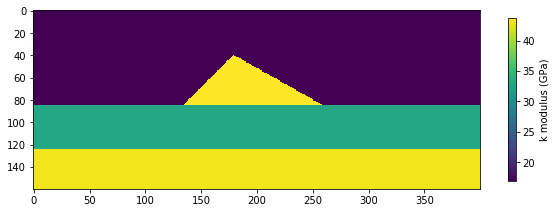

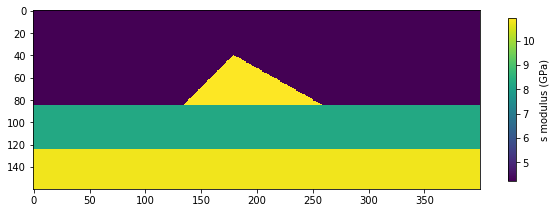

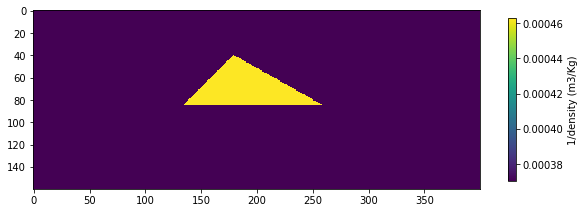

In [7]:
import numpy as np
from PIL import Image
# loading velocity from wedge image file
filename='wedge.tif'
img = Image.open(filename)
img.load()
img = img.convert('I') # gray scale, convert format
kmodulus  = np.asarray(img, dtype=np.float32)
kmodulus[:][kmodulus[:] == 255.0] = 2500.0 # initiate with velocity
kmodulus[:][kmodulus[:] == 0.0] = 4500.0
kmodulus[:][kmodulus[:] == 146.0] = 3500.0
kmodulus[:][kmodulus[:] == 36.0] = 4000.0
_1density = np.asarray(img, dtype=np.float32)
_1density[:][_1density[:] == 255.0] = 1./2700.0
_1density[:][_1density[:] == 0.0] = 1./2160.0 # salt density
_1density[:][_1density[:] == 146.0] = 1./2700.0
_1density[:][_1density[:] == 36.0] = 1./2700.0
smodulus = np.asarray(img, dtype=np.float32) 
kmodulus= (kmodulus**2)/_1density
smodulus = 0.25*kmodulus # shear modulus
plt.figure(figsize=(10,5))
im = plt.imshow(kmodulus*1e-9)
plt.colorbar(im,  shrink=0.60, pad = 0.05, label=u'k modulus (GPa)')
plt.figure(figsize=(10,5))
im = plt.imshow(smodulus*1e-9)
plt.colorbar(im,  shrink=0.60, pad = 0.05, label=u's modulus (GPa)')
plt.figure(figsize=(10,5))
im = plt.imshow(_1density)
plt.colorbar(im,  shrink=0.60, pad = 0.05, label=u'1/density (m3/Kg)')

In [8]:
@jit
def source(t, td, f):
    """first derivative of iv"""
    t = (t - td)    
    return -t*np.exp(-np.pi*(np.pi*f*t)**2)

def params(fcut, c):
    """
    From the maximum frequency of source `fcut` and
    the velocity field `c` calculates:
    ds, f center, t delay, dt time step
    """    
    # fcut max frequency in source
    f = 2*fcut/(3*np.sqrt(np.pi)) # f center
    td = 1./f # time delay    
    lmin = np.min(c)/fcut # lambda min
    ds = lmin/10. # spacing in grid to avoid spacial alias Alford
    dt = (1-1e-4)*ds/(4*np.max(c))  # "almooost" on the limit (smaller error)
    return ds, f, td, dt

nz, nx = kmodulus.shape # grid dimension
npad = 40 # abs borders

# padd k modulus model with border values
# 1st order requires +1+1 points on each dimension
# padding *2 every dimension
padk = np.pad(kmodulus, [npad+1*2, npad+1*2],  mode='edge')
nz, nx = padk.shape
padb = np.pad(_1density, [npad+1*2, npad+1*2],  mode='edge')
padm = np.pad(smodulus, [npad+1*2, npad+1*2],  mode='edge')

# source position
sj, si = npad, nx//2 # source in the middle

xt = np.zeros((nz, nx))  # Txx
zt = np.zeros((nz, nx))  # Tzz
tt = np.zeros((nz, nx))  # Txz
ut = np.zeros((nz, nx))  # Vx
vt = np.zeros((nz, nx))  # Vz
l = padk-(2/3)*padm # l=k-(2/3)m
a = l+2*padm # l+2m
#m = padm, b = padb

# simulations params, source max frequency 
vp, vs = np.sqrt(padk*padb), np.sqrt(padm*padb)
rangevelocities = [np.min(vp), np.max(vp), np.min(vs), np.max(vs)]
ds, f, td, dt = params(30., np.array(rangevelocities))
# simulation period
duracao = 1.550 # seconds
nt = int(duracao/dt)

     
print('Ds (m): {:4<.1f} f.center (Hz): {:<4.1f} ' \
      'delay (ms) : {:<4.1f}  dt (ms): {:<4.1f}  nt: {:<4d}'.format(
                    ds, f, td*1000, dt*1000, nt))


Ds (m): 4.2 f.center (Hz): 11.3 delay (ms) : 88.6  dt (ms): 0.2   nt: 6696


In [9]:
nt = 400

In [10]:
%%time

beta = dt/ds
#c = np.sqrt(padk*padb) # for absorbing boundaries

vsnaps = []
usnaps = []
for n in range(nt):
    
    stepElasticStaggered2nd(xt, zt, tt, l, padm, a, padb, ut, vt,
                            1, nx-1, 1, nz-1, dt, ds) 
    #applyDamping(ut, nx, nz, npad, 0.004)      
    #applyDamping(vt, nx, nz, npad, 0.004)      
    ut[sj, si] += -dt*source(n*dt, td, f)  
    vt[sj, si] += -dt*source(n*dt, td, f)  
    
    if n%10==0:
        vsnaps.append(vt.copy())          
        usnaps.append(ut.copy())          
        
vsnaps = np.array(vsnaps) # to array
usnaps = np.array(usnaps) # to array

Wall time: 3.47 s


In [11]:
nz, nx, sj, si

(244, 484, 40, 242)

In [12]:
vsnaps.shape

(40, 244, 484)

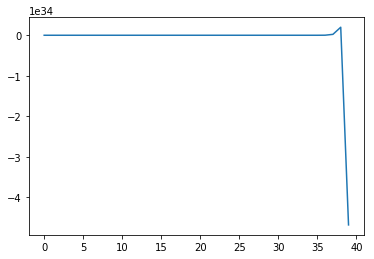

In [13]:
plt.plot(vsnaps[:300, sj, si])

In [14]:
snaps = vsnaps

## Animation Plotting!

In [13]:
plt.rcParams['animation.embed_limit'] = 1024 # in MB

In [14]:
import matplotlib
from matplotlib import animation

apad = npad+2 # 2 additional points space
pmin = np.percentile(snaps, [1])
ext = [0, nx*ds, nz*ds, 0]
fig = plt.figure(figsize=(12,6))
im = plt.imshow(snaps[0,:,:], cmap='gray_r', interpolation='none', 
                 extent=ext, alpha=0.7, vmin=-pmin, vmax=pmin)
# boundary without cerjan absortion
plt.plot([apad*ds, (nx-apad)*ds, (nx-apad)*ds, apad*ds, apad*ds], 
         [apad*ds, apad*ds, (nz-apad)*ds, (nz-apad)*ds, (apad)*ds], 'b') 
plt.colorbar(im,  shrink=0.8, pad = 0.01, aspect=10, label=u'amplitude')
plt.xlabel('x (m)')
plt.ylabel('z (m)')
title = plt.title(u'Pressure Field')
#sns.despine()
plt.tight_layout()
plt.close()

def animate(i):
    im.set_data(snaps[i*4, :, : ])

ani = animation.FuncAnimation(fig, animate, frames=int(snaps.shape[0]/4))

from IPython.display import HTML
HTML(ani.to_jshtml())

C:\Users\alferreira\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
